In [1]:
!pip install sktime
!pip install -U sagemaker

from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

     |████████████████████████████████| 5.7 MB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 38.5 MB/s eta 0:00:01
     |████████████████████████████████| 22.2 MB 52.2 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 68.5 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.11.0
    Uninstalling statsmodels-0.11.0:
      Successfully uninstalled statsmodels-0.11.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 398 kB 18.0 MB/s eta 0:00:01
  Created wheel for s

In [2]:
import sagemaker
from sagemaker.sklearn import SKLearn

sess   = sagemaker.Session(default_bucket='sagemaker-ali-playground')
bucket = sess.default_bucket()

In [3]:
import pandas as pd
import numpy as np
from sktime.datasets import load_airline

dataset = load_airline()
dataset

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [4]:
dataset.to_csv('airline.csv')

In [5]:
prefix = 'sklearn-sktime-airline'

training = sess.upload_data(path='airline.csv', key_prefix=prefix + "/training")
output   = 's3://{}/{}/output/'.format(bucket,prefix)
print(training)
print(output)

s3://sagemaker-ali-playground/sklearn-sktime-airline/training/airline.csv
s3://sagemaker-ali-playground/sklearn-sktime-airline/output/


In [6]:
import boto3

my_session = boto3.session.Session()
my_region = my_session.region_name
my_region

'eu-west-1'

In [20]:
sagemaker.image_uris.retrieve('sklearn', my_region, version='0.23-1')

'141502667606.dkr.ecr.eu-west-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3'

In [ ]:
sk = SKLearn(entry_point='sktime_sagemaker.py',
             role=sagemaker.get_execution_role(),
             framework_version='0.23-1',
             instance_count=1, 
             instance_type='ml.m5.large',
             output_path=output,
             base_job_name='sktime-test-model')

sk.fit({'training':training})

In [8]:
sk_predictor = sk.deploy(endpoint_name='sktime-naiveforcaster-19feb-v2', initial_instance_count=1, instance_type='ml.m5.large')

---------------!

In [9]:
"""data = pd.read_csv('housing.csv')
payload = data[:10].drop(['medv'], axis=1) 
payload = payload.to_csv(header=False, index=False)"""

sk_predictor.serializer = sagemaker.serializers.CSVSerializer()
#sk_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()
sk_predictor.deserializer = sagemaker.deserializers.NumpyDeserializer()

fh = np.arange(1, 37)  # we add 1 because the `stop` value is exclusive in `np.arange`
response = sk_predictor.predict(np.array([1,2,3]))

print(response)

[315. 301. 356.]


0.145427686270316

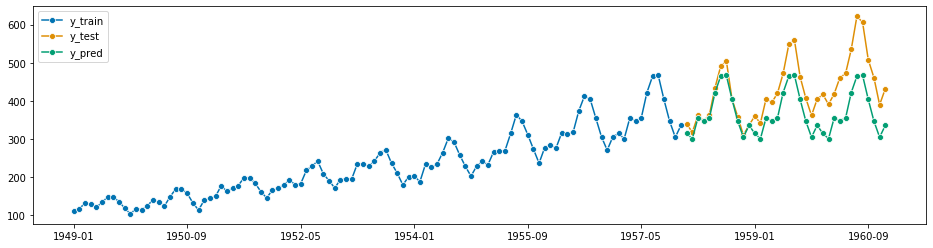

In [28]:
import numpy as np
import pandas as pd

# using sktime 
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

y = pd.Series(pd.read_csv('airline.csv')['Number of airline passengers'].values,
                    index=pd.PeriodIndex(pd.read_csv('airline.csv').Period, freq='M'))

y_train, y_test = temporal_train_test_split(y, test_size=36)

fh = np.arange(1, len(y_test) + 1)

y_pred = pd.Series(sk_predictor.predict(fh), index=y_test.index)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

In [29]:
sk_predictor.delete_endpoint()

# create endpoint

In [9]:
endpoint_name = 'sktime-test-endpoint'
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [11]:
predictor.serializer = sagemaker.serializers.CSVSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

fh = np.arange(1, 37)  # we add 1 because the `stop` value is exclusive in `np.arange`
response = predictor.predict(np.array([1,2,3]))

print(response)

[315.0, 301.0, 356.0]


0.145427686270316

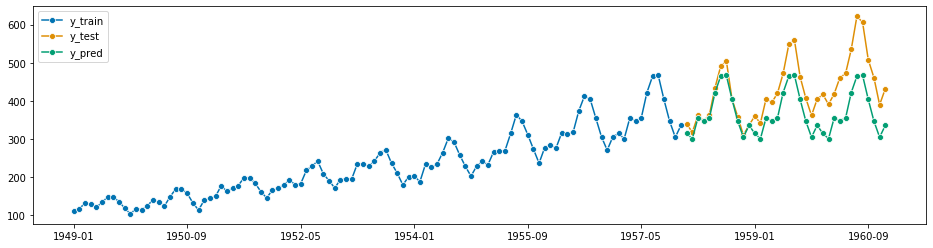

In [12]:
import numpy as np
import pandas as pd

# using sktime 
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series

y = pd.Series(pd.read_csv('airline.csv')['Number of airline passengers'].values,
                    index=pd.PeriodIndex(pd.read_csv('airline.csv').Period, freq='M'))

y_train, y_test = temporal_train_test_split(y, test_size=36)

fh = np.arange(1, len(y_test) + 1)

y_pred = pd.Series(predictor.predict(fh), index=y_test.index)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

In [13]:
predictor.delete_endpoint()